In [3]:
!pip install tqdm

In [13]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
from time import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import random
import torch 
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO

In [14]:
random_seed = 2109
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

data_dir = "/opt/ml/segmentation/input/data/"
json_all_path = "/opt/ml/segmentation/input/data/train_all.json"
json_eval_path = "/opt/ml/segmentation/input/data/val.json"
# json_all_data json_eval_data 

In [173]:
category_names = ['Backgroud',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir,img_path, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.img_path =img_path
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(self.img_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return 30
        # return len(self.coco.getImgIds())

# image size, rgb mean, std

In [154]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        img = np.array(Image.open(os.path.join(img_dir, img_id)))
        h, w, _ = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [155]:
# trian
with open(json_all_path, 'r') as j :
    json_all_data = json.load(j)
    img_all_file = []
    
for x in json_all_data["images"]:
    img_all_file.append(x["file_name"])
    
# eval
with open(json_eval_path, 'r') as j :
    json_eval_data = json.load(j)
    img_eval_file = []
    
for x in json_eval_data["images"]:
    img_eval_file.append(x["file_name"])

In [156]:
img_all_info = get_img_stats(data_dir, img_all_file)
img_eval_info = get_img_stats(data_dir, img_eval_file)

100%|██████████| 655/655 [00:21<00:00, 30.57it/s]


### Train

In [157]:
print(f'Total number of images is {len(img_all_file)}')
print()
print(f'Minimum height for dataset is {np.min(img_all_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_all_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_all_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_all_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_all_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_all_info["widths"]))}')
print()
print(f'RGB Mean: {np.mean(img_all_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_all_info["stds"], axis=0) / 255.}')

Total number of images is 3272

Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 512
Maximum width for dataset is 512
Average width for dataset is 512

RGB Mean: [0.46009655 0.43957878 0.41827092]
RGB Standard Deviation: [0.2108204  0.20766491 0.21656131]


### Eval

In [158]:
print(f'Total number of images is {len(img_eval_file)}')
print()
print(f'Minimum height for dataset is {np.min(img_eval_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_eval_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_eval_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_eval_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_eval_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_eval_info["widths"]))}')
print()
print(f'RGB Mean: {np.mean(img_eval_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_eval_info["stds"], axis=0) / 255.}')

Total number of images is 655

Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 512
Maximum width for dataset is 512
Average width for dataset is 512

RGB Mean: [0.46034062 0.43985595 0.4168375 ]
RGB Standard Deviation: [0.21103533 0.20915556 0.21880394]


# EDA

# stratifiedkfold

In [174]:
# ann_path = json_all_path
ann_path = "/opt/ml/segmentation/input/data/train_all.json"
img_path ="/opt/ml/segmentation/input/data/"
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            # A.GridDropout(holes_number_x =30, holes_number_y=30, p=1.0),
                            ToTensorV2()
                            ])

train_dataset = CustomDataLoader(data_dir=ann_path, img_path = img_path, mode='train', transform=train_transform)
print(len(train_dataset))

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                            batch_size=16,
#                                            shuffle=True,
#                                            num_workers=4,
#                                            collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.49s)
creating index...
index created!
30


In [175]:
images, masks, image_infos =train_dataset[0]

In [193]:
list(np.unique(masks))

[0, 2, 3, 4, 6, 8]

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 1}, {2, 'Paper'}, {'Plastic', 6}, {'Styrofoam', 7}, {8, 'Plastic bag'}]


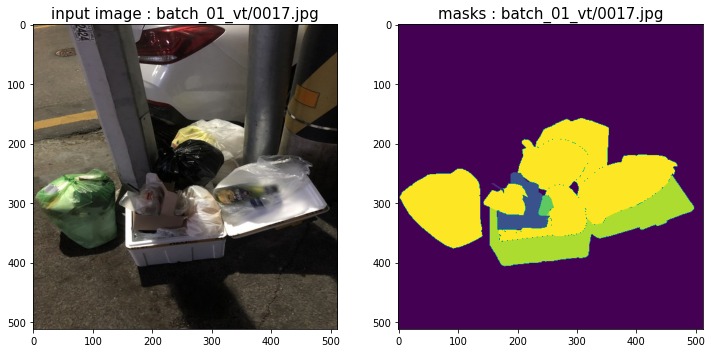

In [74]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [84]:
# https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold
# https://github.com/trent-b/iterative-stratification
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit,
                                     StratifiedGroupKFold)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5

In [178]:
anns = json_all_data["annotations"]
# print(anns[0])
cat_histogram = np.zeros(10,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

cat_name =  ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

print(cat_histogram)
print(cat_histogram)
test = []
for i, x in enumerate(cat_histogram):
    test.extend([i] * x)
# print([ [i] * x for i, x in enumerate(cat_histogram)])
len(test)

[2782 9311  659  562  610 3090 1343 7643   63  177]
[2782 9311  659  562  610 3090 1343 7643   63  177]


26240

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 ... 9 9 9]


/opt/conda/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


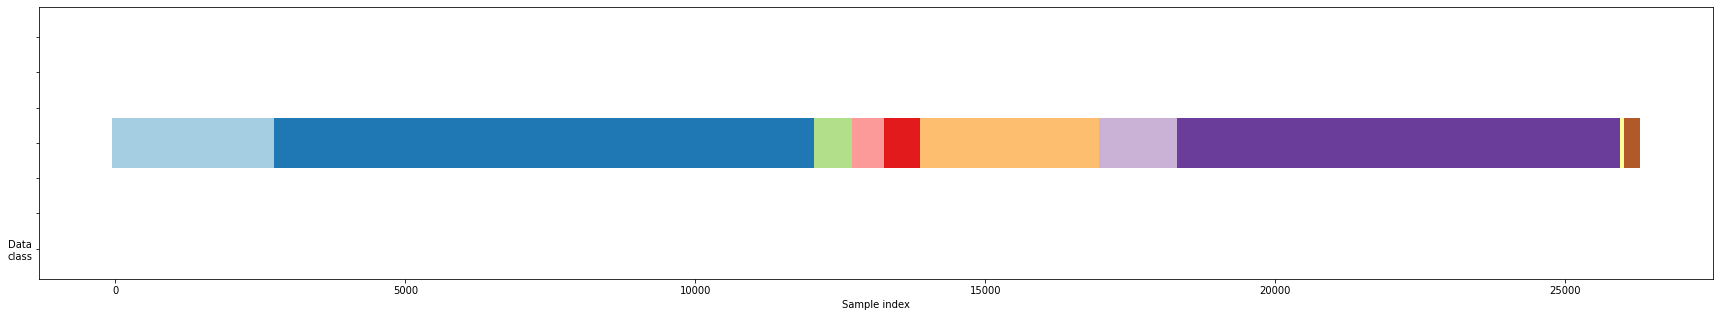

In [131]:
# Generate the class/group data
n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])


# Evenly spaced groups repeated once
groups = np.hstack([[ii] * 2624 for ii in range(10)])

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize = (30, 5))
    # ax.scatter(range(len(classes)),  [.7] * len(groups), c=groups, marker='_',
    #            lw=50, cmap=cmap_data)
    ax.scatter(range(len(classes)),  [3.5] * len(classes), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(yticklabels=['Data\ngroup', 'Data\nclass'], xlabel="Sample index")
            #ylim=[-1, 5], yticks=[0.7, 3.5],


visualize_groups(test, groups, 'no groups')

In [133]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [168]:
x, y, z = train_dataset[10]
print(y.shape)
print(z)

torch.Size([512, 512])
{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0014.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 10}


In [181]:
kfold = KFold(n_splits=5, shuffle=False, random_state=None)
kfold.get_n_splits(train_dataset)
print(kfold)

print(len(train_dataset))

for train_index, val_index in kfold.split(train_dataset):
    print(f"train {train_index}, val {val_index}")
    break

KFold(n_splits=5, random_state=None, shuffle=False)
30
train [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29], val [0 1 2 3 4 5]


In [182]:
!pip install iterative-stratification

In [215]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
msss = MultilabelStratifiedKFold(n_splits=3,  shuffle=True, random_state=2019)


y = np.array()
x = []
for i, index in enumerate(range(len(train_dataset))):
    images, masks, image_infos = train_dataset[index]
    y.append(list(np.unique(masks)))
    x.append(images)
print(x)
print(y)
print(y.to_numpy(dtype=np.float32))

print(len(x))
print(len(y))

TypeError: array() missing required argument 'object' (pos 0)

In [211]:
for train_index, test_index in msss.split(x, y):
    print(f"train {train_index}, val {val_index}")

/opt/conda/envs/segmentation/lib/python3.7/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


ValueError: Supported target type is: multilabel-indicator. Got 'binary' instead.

ValueError: Found input variables with inconsistent numbers of samples: [26240, 100, 26240]

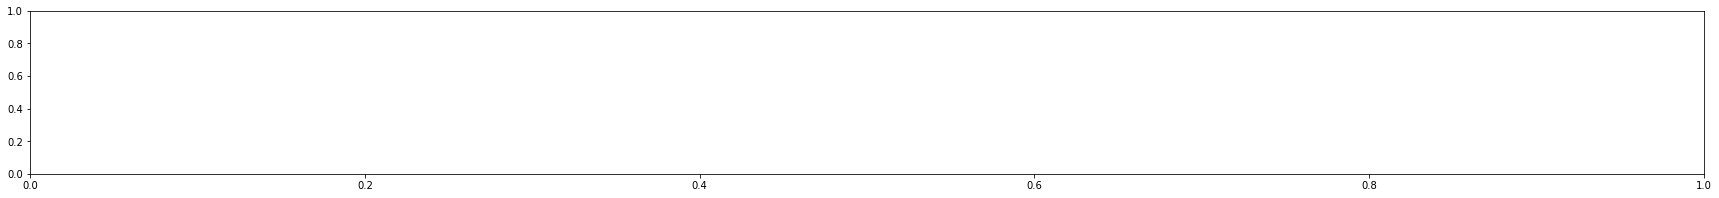

In [144]:
# To better demonstrate the difference, we will assign samples to groups
# unevenly:
# print(X)
uneven_groups = np.sort(np.random.randint(0, 10, len(test)))

cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]


test

for cv in cvs:
    fig, ax = plt.subplots(figsize=(30, 3))
    plot_cv_indices(cv(n_splits), test, y, uneven_groups, ax, n_splits)
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)